# Load data

In [3]:
!pip install rasterio

zsh:1: command not found: pip


In [2]:
import geopandas as gpd
import pandas as pd

In [4]:
subbasin_gdf = gpd.read_file('../data/raw/hydrography/gsl_catchment.shp')
gage_df = pd.read_csv('../data/raw/hydrography/gsl_nwm_gage.csv')
well_gdf = gpd.read_file('../data/raw/hydrography/well_shp.shp')
stream_gdf = gpd.read_file('../data/raw/hydrography/gslb_stream.shp')
lake_gdf = gpd.read_file('../data/raw/hydrography/lake.shp')

# find downstream gage

In [11]:
from geopandas import GeoDataFrame
from shapely.geometry import Point

# Convert gage dataframe to GeoDataFrame (to match with subbasin_gdf)
# Create point geometries from longitude/latitude coordinates
gage_gdf = gpd.GeoDataFrame(
    gage_df,
    geometry=gpd.points_from_xy(gage_df['longitude'], gage_df['latitude']),
    crs=subbasin_gdf.crs
)

# Spatial join to find which subbasin each gage falls within
# Only keep gages that are within a subbasin (inner join)
matched_gages = gpd.sjoin(
    gage_gdf[['id', 'name', 'geometry']],
    subbasin_gdf[['linkno', 'geometry']],
    how='inner',
    predicate='within'
).rename(columns={'linkno': 'catchment_id'})

# Keep only relevant columns
matched_gages = matched_gages[['id', 'name', 'geometry', 'catchment_id']]



In [12]:
# Create a directed graph representing the river network
import networkx as nx
G = nx.DiGraph()

# Add edges to graph based on stream connectivity
# DSLINKNO represents downstream link number
for _, row in stream_gdf.iterrows():
    if pd.notna(row['DSLINKNO']) and row['DSLINKNO'] > 0:
        G.add_edge(int(row['LINKNO']), int(row['DSLINKNO']))

# Create dictionary mapping gage IDs to their catchment IDs
gage_links = dict(zip(matched_gages['id'], matched_gages['catchment_id']))
terminal_ids = []

# Find terminal gages (those that don't flow to any other gage)
for g1_id, g1_link in gage_links.items():
    is_terminal = True
    for g2_id, g2_link in gage_links.items():
        if g1_id != g2_id:
            try:
                # If there's a path from g1 to g2, then g1 is not terminal
                if nx.has_path(G, g1_link, g2_link):
                    is_terminal = False
                    break
            except:
                continue
    if is_terminal:
        terminal_ids.append(g1_id)

In [13]:
# Manual adjustments to terminal gages list based on domain knowledge
gages_to_remove = [10171000, 10167000]
gages_to_add = [10163000, 10153100, 10152000]

In [14]:
# Remove specified gages
terminal_ids = [gage_id for gage_id in terminal_ids if gage_id not in gages_to_remove]

# Add new gages if they exist in matched_gages
for gage_id in gages_to_add:
    if gage_id in matched_gages['id'].values and gage_id not in terminal_ids:
        terminal_ids.append(gage_id)

# Create dataframe of terminal gages
terminal_gages = matched_gages[matched_gages['id'].isin(terminal_ids)].copy()

# Find all upstream catchments for each terminal gage
records = []
for _, gage in terminal_gages.iterrows():
    upstream_ids = set()
    # Check each node in the graph
    for node in G.nodes:
        # If there's a path from node to terminal gage's catchment,
        # then this node is upstream
        if nx.has_path(G, node, gage['catchment_id']):
            upstream_ids.add(node)
    # Include the terminal gage's own catchment
    upstream_ids.add(gage['catchment_id'])

    # Create records for each upstream catchment
    for up_id in upstream_ids:
        records.append({
            'Gage_ID': gage['id'],
            'Gage_Name': gage['name'],
            'Terminal_Catchment_ID': gage['catchment_id'],
            'Upstream_Catchment_ID': up_id
        })

# Create and save the final dataframe
df_upstream = pd.DataFrame(records)
df_upstream.to_csv("../data/processed/terminal_gage_upstream_catchments.csv", index=False)

In [16]:
print(f'Number of unique gages in df_upstream: {df_upstream["Gage_ID"].nunique()}')
print('\nTerminal gage names:')
for _, row in df_upstream[['Gage_ID', 'Gage_Name']].drop_duplicates().iterrows():
    print(f'{row["Gage_ID"]}: {row["Gage_Name"]}')


Number of unique gages in df_upstream: 12

Terminal gage names:
10126000: BEAR RIVER NEAR CORINNE - UT
10141000: WEBER RIVER NEAR PLAIN CITY - UT
10142000: FARMINGTON CR ABV DIV NR FARMINGTON - UTAH
10143500: CENTERVILLE CREEK ABV. DIV NEAR CENTERVILLE - UT
10152000: SPANISH FORK NEAR LAKE SHORE - UTAH
10153100: HOBBLE CREEK AT 1650 WEST AT SPRINGVILLE - UTAH
10163000: PROVO RIVER AT PROVO - UT
10168000: LITTLE COTTONWOOD CREEK @ JORDAN RIVER NR SLC
10168500: BIG COTTONWOOD CR NR SALT LAKE CITY UTAH
10172700: VERNON CREEK NEAR VERNON - UT
10172860: WARM CREEK NEAR GANDY - UT
10172952: DUNN CREEK NEAR PARK VALLEY - UT


# Plot

In [22]:
import matplotlib.pyplot as plt
plt.style.use('default')  # Reset any style settings

In [17]:
import plotly as plt
import plotly.express as px

=== Creating Enhanced Watershed Visualization ===


FileNotFoundError: [Errno 2] No such file or directory: '..reports/figures/enhanced_terminal_gages_watersheds.png'

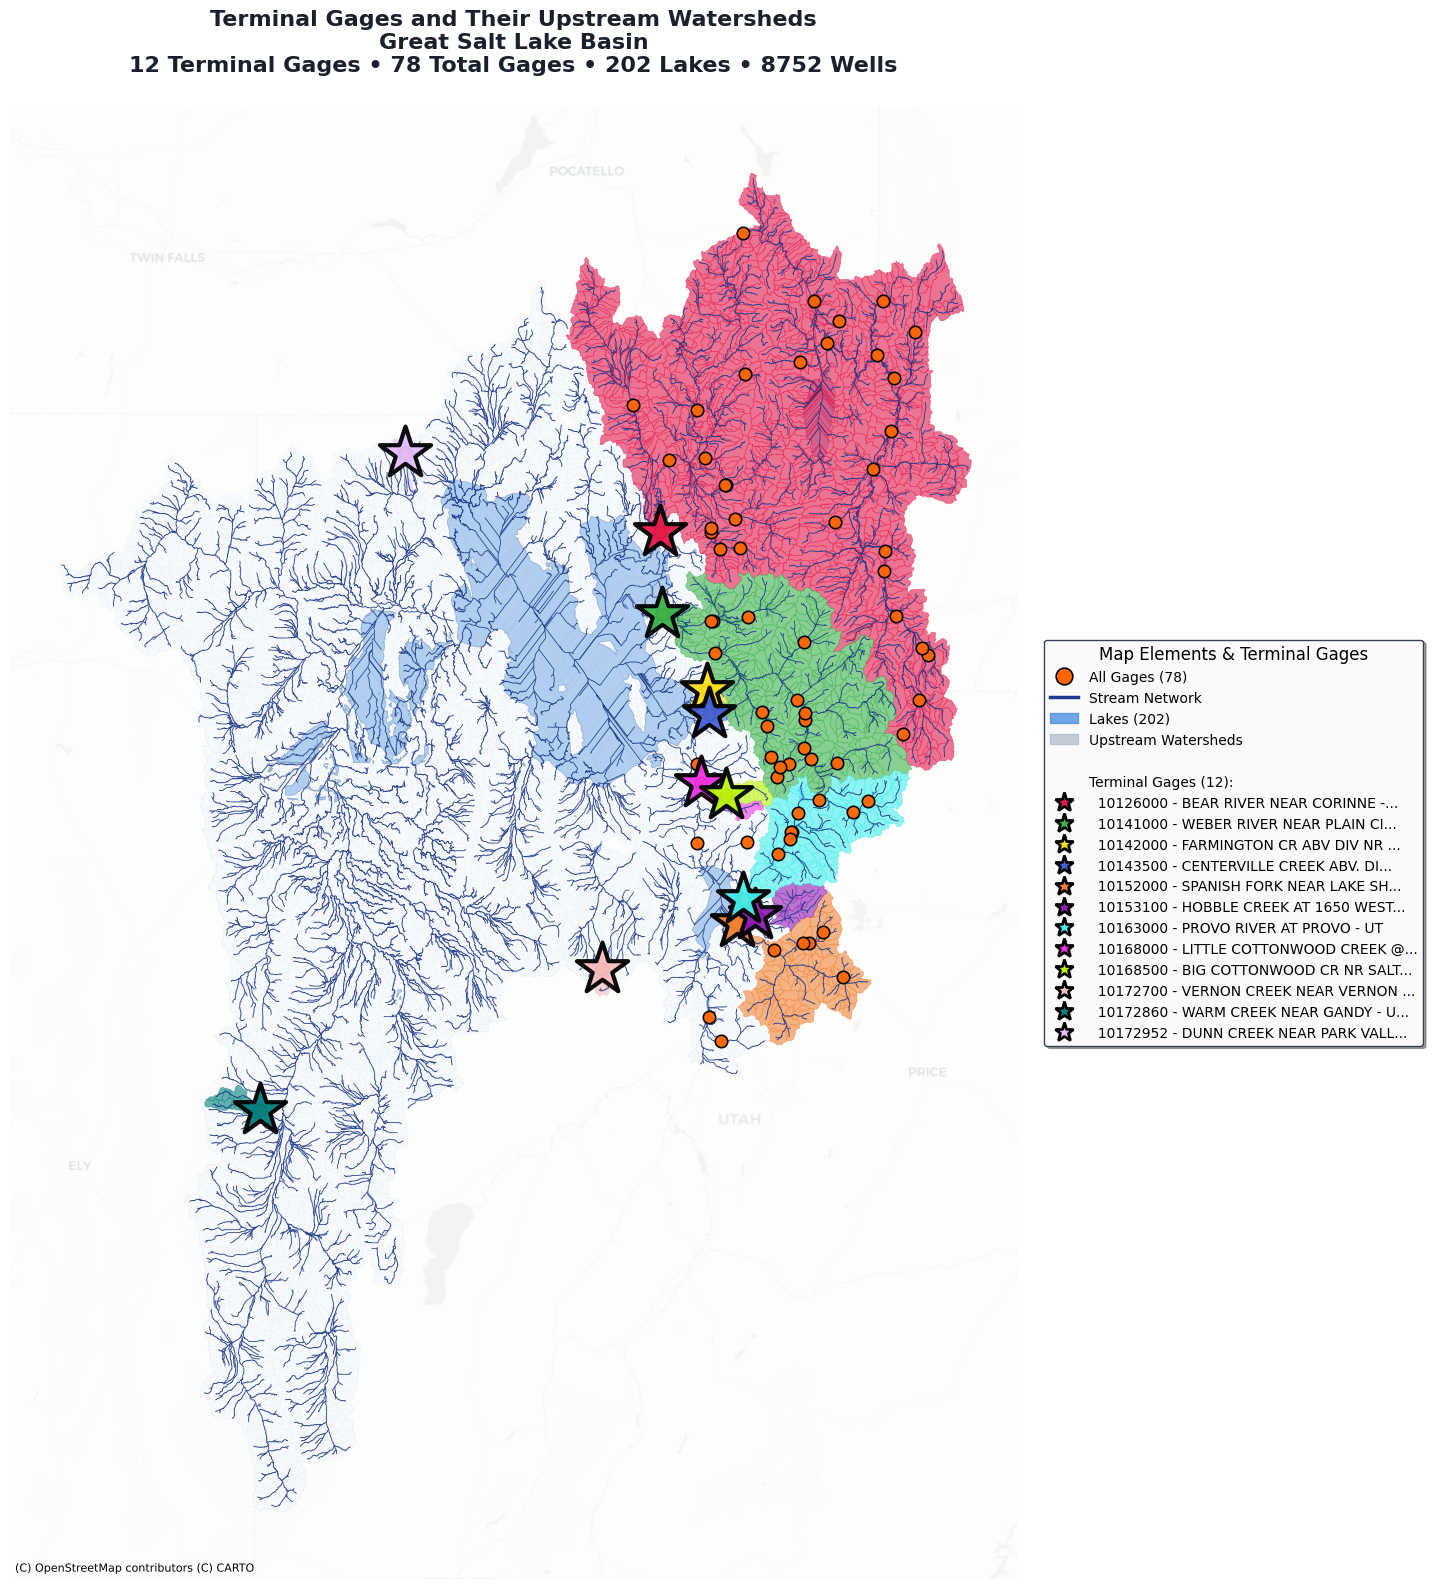

In [24]:
def create_enhanced_watershed_visualization():
    """
    Create enhanced watershed visualization with bright colors and large gages
    """
    print("=== Creating Enhanced Watershed Visualization ===")

    # Load data
    terminal_mapping = pd.read_csv('../data/processed/terminal_gage_upstream_catchments.csv')
    subbasin_gdf = gpd.read_file('../data/raw/hydrography/gsl_catchment.shp')
    gage_df = pd.read_csv('../data/raw/hydrography/gsl_nwm_gage.csv')
    well_gdf = gpd.read_file('../data/raw/hydrography/well_shp.shp')
    stream_gdf = gpd.read_file('../data/raw/hydrography/gslb_stream.shp')
    lake_gdf = gpd.read_file('../data/raw/hydrography/lake.shp')
    # Find linkno column
    linkno_col = 'linkno' if 'linkno' in subbasin_gdf.columns else 'LINKNO'

    # Data preprocessing
    if 'Gage_ID' in terminal_mapping.columns:
        terminal_mapping = terminal_mapping.rename(columns={
            'Gage_ID': 'gage_id',
            'Upstream_Catchment_ID': 'upstream_catchment_id'
        })

    terminal_mapping = terminal_mapping.dropna(subset=['upstream_catchment_id'])
    terminal_mapping['gage_id'] = terminal_mapping['gage_id'].astype(int)
    terminal_mapping['upstream_catchment_id'] = terminal_mapping['upstream_catchment_id'].astype(int)

    gage_df['id'] = gage_df['id'].astype(int)
    subbasin_gdf = subbasin_gdf.dropna(subset=[linkno_col])
    subbasin_gdf[linkno_col] = subbasin_gdf[linkno_col].astype(int)

    # Get terminal gages and create catchments dictionary
    terminal_gage_ids = terminal_mapping['gage_id'].unique().tolist()
    terminal_gages = gage_df[gage_df['id'].isin(terminal_gage_ids)].copy()

    terminal_gage_catchments = {}
    available_catchments = set(subbasin_gdf[linkno_col].unique())

    for gage_id in terminal_gage_ids:
        upstream_catchments = terminal_mapping[
            terminal_mapping['gage_id'] == gage_id
        ]['upstream_catchment_id'].tolist()

        valid_catchments = [c for c in upstream_catchments if c in available_catchments]
        if valid_catchments:
            terminal_gage_catchments[gage_id] = set(valid_catchments)

    # Convert to Web Mercator
    subbasin_web = subbasin_gdf.to_crs('EPSG:3857')
    stream_web = stream_gdf.to_crs('EPSG:3857')
    lake_web = lake_gdf.to_crs('EPSG:3857')
    well_web = well_gdf.to_crs('EPSG:3857')  # Convert wells to Web Mercator

    gage_gdf_web = gpd.GeoDataFrame(
        gage_df,
        geometry=gpd.points_from_xy(gage_df['longitude'], gage_df['latitude']),
        crs='EPSG:4326'
    ).to_crs('EPSG:3857')

    terminal_gages_web = gpd.GeoDataFrame(
        terminal_gages,
        geometry=gpd.points_from_xy(terminal_gages['longitude'], terminal_gages['latitude']),
        crs='EPSG:4326'
    ).to_crs('EPSG:3857')

    # New bright professional colors
    bright_colors = [
    '#E6194B',  # 鲜红
    '#3CB44B',  # 明绿
    '#FFE119',  # 鲜黄
    '#4363D8',  # 宝蓝
    '#F58231',  # 橘色
    '#911EB4',  # 紫罗兰
    '#46F0F0',  # 湖蓝
    '#F032E6',  # 品红
    '#BCF60C',  # 黄绿
    '#FABEBE',  # 淡粉
    '#008080',  # 青绿色
    '#E6BEFF',  # 淡紫
    '#9A6324',  # 褐色
    '#FFFAC8',  # 象牙黄
    '#800000',  # 深红
    '#AAFFC3',  # 薄荷绿
    '#808000',  # 橄榄绿
    '#FFD8B1',  # 杏橙
    '#000075',  # 海军蓝
    '#808080'   # 中灰色
]

    terminal_gage_colors = dict(zip(terminal_gage_ids, bright_colors[:len(terminal_gage_ids)]))

    # Create plot
    fig, ax = plt.subplots(1, 1, figsize=(22, 16))

    # 1. Plot subbasins background
    subbasin_web.plot(ax=ax, color='#F7FAFC', edgecolor='#E2E8F0', linewidth=0.1, alpha=0.9, zorder=1)

    # 2. Add lakes (darker blue, more visible)
    lake_web.plot(ax=ax, color='#4A90E2', edgecolor='#2E5F8A',  # Changed to darker blue
                  linewidth=0.5, alpha=0.4, zorder=1.5)  # Increased alpha for better visibility

    # 3. Highlight watersheds
    for gage_id in terminal_gage_ids:
        if gage_id in terminal_gage_catchments:
            upstream_catchments = list(terminal_gage_catchments[gage_id])
            upstream_basins = subbasin_web[subbasin_web[linkno_col].isin(upstream_catchments)]

            if not upstream_basins.empty:
                upstream_basins.plot(
                    ax=ax,
                    color=terminal_gage_colors[gage_id],
                    alpha=0.6,
                    edgecolor=terminal_gage_colors[gage_id],
                    linewidth=0.3,
                    zorder=2
                )

    # 4. Add streams (dark blue)
    stream_web.plot(ax=ax, color='#1E3A8A', linewidth=0.6, alpha=0.9, zorder=3)


    # 6. Plot all gages (bright and large)
    gage_gdf_web.plot(ax=ax, color='#FF6600', markersize=80, alpha=0.95,  # Much larger and brighter
                      edgecolor='#000000', linewidth=1.2, zorder=4)

    # 7. Plot terminal gages (bright stars)
    terminal_gage_info = []
    for _, row in terminal_gages_web.iterrows():
        gage_id = int(row['id'])

        if gage_id in terminal_gage_catchments:
            x_coord = row.geometry.x
            y_coord = row.geometry.y

            ax.scatter([x_coord], [y_coord],
                       c=[terminal_gage_colors[gage_id]],
                       marker='*', s=1500,  # Larger stars
                       edgecolors='#000000', linewidths=3.0,
                       zorder=5, alpha=0.95)

            # Collect info for legend
            gage_name = row.get('name', f'Gage {gage_id}')
            river = row.get('River', 'Unknown River')
            terminal_gage_info.append({
                'id': gage_id,
                'name': gage_name,
                'river': river,
                'color': terminal_gage_colors[gage_id]
            })

    # 8. Add base map
    try:
        import contextily as ctx
        ctx.add_basemap(ax, crs=subbasin_web.crs,
                        source=ctx.providers.CartoDB.Positron,
                        zorder=0, alpha=0.3)
    except:
        pass

    # 9. Create legend
    from matplotlib.patches import Patch

    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w',
                  markerfacecolor='#FF6600', markersize=12,
                  markeredgecolor='#000000', markeredgewidth=1.2,
                  label=f'All Gages ({len(gage_df)})'),
        plt.Line2D([0], [0], color='#1E3A8A', linewidth=2.5,
                  label='Stream Network'),
        Patch(color='#4A90E2', alpha=0.8, label=f'Lakes ({len(lake_gdf)})'),  # Updated lake color in legend
        Patch(color='#A0AEC0', alpha=0.6, label='Upstream Watersheds'),
        plt.Line2D([0], [0], color='none', label=''),  # Spacer
        plt.Line2D([0], [0], color='none', label=f'Terminal Gages ({len(terminal_gage_info)}):')
    ]

    # Add terminal gages to legend
    terminal_gage_info.sort(key=lambda x: x['id'])
    for info in terminal_gage_info:
        display_name = info['name'][:25] + "..." if len(info['name']) > 25 else info['name']
        legend_elements.append(
            plt.Line2D([0], [0], marker='*', color='w',
                      markerfacecolor=info['color'], markersize=14,
                      markeredgecolor='#000000', markeredgewidth=2.0,
                      label=f'  {info["id"]} - {display_name}')
        )

    # Set legend
    ax.legend(handles=legend_elements,
             loc='center left', bbox_to_anchor=(1.02, 0.5),
             fontsize=10, title='Map Elements & Terminal Gages',
             title_fontsize=12, frameon=True, fancybox=True,
             shadow=True, framealpha=0.95, facecolor='white',
             edgecolor='#2D3748')

    # 10. Title
    ax.set_title(f"Terminal Gages and Their Upstream Watersheds\n"
                f"Great Salt Lake Basin\n"
                f"{len(terminal_gage_ids)} Terminal Gages • {len(gage_df)} Total Gages • {len(lake_gdf)} Lakes • {len(well_gdf)} Wells",
                fontsize=16, pad=25, fontweight='bold', color='#1A202C')

    # 11. Format and save
    ax.set_aspect('equal')
    ax.axis('off')
    ax.margins(0.01)
    plt.tight_layout()

    import os
    plt.savefig("../reports/figures/enhanced_terminal_gages_watersheds.png",
                dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.show()

    print(f"✅ Visualization saved to: reports/figures/enhanced_terminal_gages_watersheds.png")
    print(f"📊 Added {len(well_gdf)} wells to the visualization")

# Run visualization
create_enhanced_watershed_visualization()
